In [104]:
import os, shutil
from os import listdir
from os.path import isfile, join
from sklearn.model_selection import train_test_split
import tensorflow as tf
import numpy as np
from time import time
import numpy as np
import keras.backend as K
from keras.engine.topology import Layer, InputSpec
from keras.layers import Dense, Input
from keras.models import Model
from keras.optimizers import SGD
from keras import callbacks
from keras.initializers import VarianceScaling
from sklearn.cluster import KMeans
import random
import metrics

from keras.models import Model
from keras import backend as K
from keras import layers
from keras.layers import Input, Dense, Conv2D, MaxPooling2D, UpSampling2D, Flatten, Reshape, Conv2DTranspose
from keras.models import Model
import numpy as np


random.seed(1)

In [50]:
# original data directories
CT = '../Data/CT/'
MRI = '../Data/MRI/'
PET = '../Data/PET/'

myPaths = [CT, MRI, PET]
myDict={CT:[], MRI:[], PET:[]}

#creo il dizionario con le liste delle immagini
for path in myPaths:
    myDict[path] = [f for f in listdir(path) if isfile(join(path, f))]

#split train test
split_at = 0.8

CT_train, CT_test = train_test_split(myDict[myPaths[0]], train_size=split_at)
MRI_train, MRI_test = train_test_split(myDict[myPaths[1]], train_size=split_at)
PET_train, PET_test = train_test_split(myDict[myPaths[2]], train_size=split_at)

#split train validation
#CT_train, CT_validation = train_test_split(CT_train, train_size=split_at)
#MRI_train, MRI_validation = train_test_split(MRI_train, train_size=split_at)
#PET_train, PET_validation = train_test_split(PET_train, train_size=split_at)

#train e test lists
train_file_names = CT_train + MRI_train + PET_train
#validation = CT_validation + MRI_validation + PET_validation
test_file_names = CT_test + MRI_test + PET_test

#print(train_file_names)

In [51]:
#data/
print('Creo la directory "data/ in questa posizione:', os.getcwd())

directories = ['data/train/', 
               #'data/validation', 
               'data/test/']

#cancello directory precedente per evitare errori
if os.path.exists('data/'):
    shutil.rmtree('data/', ignore_errors=True) 

#creo le direcotories data/train, data/test
for directory in directories:
        os.makedirs(directory)

#copio le immagini di train in data/train
scans = ['CT', 'MRI', 'PET']
for source,scan in zip(myPaths, scans):
    train_files = eval(scan+'_train')
    for f in train_files:
        shutil.copy(source+f, directories[0])
        
#copio le immagini di test in data/test
for source,scan in zip(myPaths, scans):
    test_files = eval(scan+'_test')
    for f in test_files:
        shutil.copy(source+f, directories[1])
        
print("Dati trasferiti con successo in data/train e data/test.")
print("Dimensione database: Training:", len(train_file_names), " Test:", len(test_file_names))

Creo la directory "data/ in questa posizione: /Users/orobix/Documents/Thesis/Source/Code
Dati trasferiti con successo in data/train e data/test.
Dimensione database: Training: 851  Test: 214


x shape: (1065, 128, 128, 1)
y shape: (1065,)
Number of categories: 3


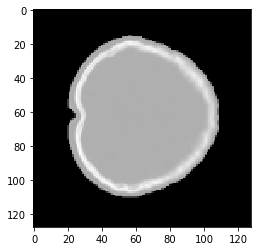

In [89]:
from skimage import io
import matplotlib.pyplot as plt
import cv2

# ***
# TO DO: CONCATENARE ANCHE LE IMMAGINI IN TEST
# ***

# lista per fare image reading
location_train_file_names = [directories[0] + item for item in train_file_names]
location_test_file_names = [directories[1] + item for item in test_file_names]


#x_train
x_train = io.imread(location_train_file_names[random.randint(0,9)])
x_train = cv2.resize(x_train, dsize=(128,128))
plt.imshow(x_train, cmap=plt.cm.gray)

#stack images
for img in location_train_file_names[1:]: #parti dalla seconda immagine
    img = io.imread(img)
    img = cv2.resize(img, dsize=(128,128))
    x_train = np.dstack((x_train,img))
x_train = np.rollaxis(x_train,-1) #(182,218,N)->(N,182,218)
#print('x_train shape:',x_train.shape)
    

#x_test
x_test = io.imread(location_test_file_names[random.randint(0,9)])
x_test = cv2.resize(x_test, dsize=(128,128))
plt.imshow(x_test, cmap=plt.cm.gray)

#stack images
for img in location_test_file_names[1:]: #parti dalla seconda immagine
    img = io.imread(img)
    img = cv2.resize(img, dsize=(128,128))
    x_test = np.dstack((x_test,img))
x_test = np.rollaxis(x_test,-1) #(182,218,N)->(N,182,218)
#print('x_test shape:',x_test.shape)


#make labels y for metrics: CT==0, MRI==1, PET==2
ext = '.png'
y_train = []
for text in listdir('data/train'):
    fileNameOnly = text[:text.find(ext)]
    y_train.append(''.join([i for i in fileNameOnly if not i.isdigit()]))
for i, item in enumerate(y_train):
    if item == 'CT':
        y_train[i] = 0
    elif item == 'MRI':
        y_train[i] = 1
    else: y_train[i] = 2        

#make labels y for metrics: CT==0, MRI==1, PET==2
ext = '.png'
y_test = []
for text in listdir('data/test'):
    fileNameOnly = text[:text.find(ext)]
    y_test.append(''.join([i for i in fileNameOnly if not i.isdigit()]))
for i, item in enumerate(y_test):
    if item == 'CT':
        y_test[i] = 0
    elif item == 'MRI':
        y_test[i] = 1
    else: y_test[i] = 2

x = np.concatenate((x_train,x_test))
y = np.concatenate((y_train,y_test))
x = x.reshape(x.shape + (1,))
x = x/255.
print('x shape:', x.shape)
print('y shape:', y.shape)

#numero di clusters. (3)
n_clusters = len(np.unique(y))
print('Number of categories:', n_clusters)

## Pretrain a convolutional autoencoder

In [76]:
def autoencoder(dims, act='relu', init='glorot_uniform'):
    """
    Fully connected auto-encoder model, symmetric.
    Arguments:
        dims: list of number of units in each layer of encoder. dims[0] is input dim, dims[-1] is units in hidden layer.
            The decoder is symmetric with encoder. So number of layers of the auto-encoder is 2*len(dims)-1
        act: activation, not applied to Input, Hidden and Output layers
    return:
        (ae_model, encoder_model), Model of autoencoder and model of encoder
    """
    n_stacks = len(dims) - 1
    # input
    input_img = Input(shape=(dims[0],), name='input')
    x = input_img
    # internal layers in encoder
    for i in range(n_stacks-1):
        x = Dense(dims[i + 1], activation=act, kernel_initializer=init, name='encoder_%d' % i)(x)

    # hidden layer
    encoded = Dense(dims[-1], kernel_initializer=init, name='encoder_%d' % (n_stacks - 1))(x)  # hidden layer, features are extracted from here

    x = encoded
    # internal layers in decoder
    for i in range(n_stacks-1, 0, -1):
        x = Dense(dims[i], activation=act, kernel_initializer=init, name='decoder_%d' % i)(x)

    # output
    x = Dense(dims[0], kernel_initializer=init, name='decoder_0')(x)
    decoded = x
    return Model(inputs=input_img, outputs=decoded, name='AE'), Model(inputs=input_img, outputs=encoded, name='encoder')

In [77]:
class ClusteringLayer(Layer):
    """
    Clustering layer converts input sample (feature) to soft label, i.e. a vector that represents the probability of the
    sample belonging to each cluster. The probability is calculated with student's t-distribution.

    # Example
    ```
        model.add(ClusteringLayer(n_clusters=10))
    ```
    # Arguments
        n_clusters: number of clusters.
        weights: list of Numpy array with shape `(n_clusters, n_features)` witch represents the initial cluster centers.
        alpha: degrees of freedom parameter in Student's t-distribution. Default to 1.0.
    # Input shape
        2D tensor with shape: `(n_samples, n_features)`.
    # Output shape
        2D tensor with shape: `(n_samples, n_clusters)`.
    """

    def __init__(self, n_clusters, weights=None, alpha=1.0, **kwargs):
        if 'input_shape' not in kwargs and 'input_dim' in kwargs:
            kwargs['input_shape'] = (kwargs.pop('input_dim'),)
        super(ClusteringLayer, self).__init__(**kwargs)
        self.n_clusters = n_clusters
        self.alpha = alpha
        self.initial_weights = weights
        self.input_spec = InputSpec(ndim=2)

    def build(self, input_shape):
        assert len(input_shape) == 2
        input_dim = input_shape[1]
        self.input_spec = InputSpec(dtype=K.floatx(), shape=(None, input_dim))
        self.clusters = self.add_weight(shape=(self.n_clusters, input_dim), initializer='glorot_uniform', name='clusters')
        if self.initial_weights is not None:
            self.set_weights(self.initial_weights)
            del self.initial_weights
        self.built = True

    def call(self, inputs, **kwargs):
        """ student t-distribution, as same as used in t-SNE algorithm.
         Measure the similarity between embedded point z_i and centroid µ_j.
                 q_ij = 1/(1+dist(x_i, µ_j)^2), then normalize it.
                 q_ij can be interpreted as the probability of assigning sample i to cluster j.
                 (i.e., a soft assignment)
        Arguments:
            inputs: the variable containing data, shape=(n_samples, n_features)
        Return:
            q: student's t-distribution, or soft labels for each sample. shape=(n_samples, n_clusters)
        """
        q = 1.0 / (1.0 + (K.sum(K.square(K.expand_dims(inputs, axis=1) - self.clusters), axis=2) / self.alpha))
        q **= (self.alpha + 1.0) / 2.0
        q = K.transpose(K.transpose(q) / K.sum(q, axis=1)) # Make sure each sample's 10 values add up to 1.
        return q

    def compute_output_shape(self, input_shape):
        assert input_shape and len(input_shape) == 2
        return input_shape[0], self.n_clusters

    def get_config(self):
        config = {'n_clusters': self.n_clusters}
        base_config = super(ClusteringLayer, self).get_config()
        return dict(list(base_config.items()) + list(config.items()))

### Autoencoder Conv2D_1

In [79]:
def autoencoderConv2D_1(input_shape=(128, 128, 1), filters=[32, 64, 128, 3]):
    input_img = Input(shape=input_shape)
    if input_shape[0] % 8 == 0:
        pad3 = 'same'
    else:
        pad3 = 'valid'
    x = Conv2D(filters[0], 5, strides=2, padding='same', activation='relu', name='conv1', input_shape=input_shape)(input_img)

    x = Conv2D(filters[1], 5, strides=2, padding='same', activation='relu', name='conv2')(x)

    x = Conv2D(filters[2], 3, strides=2, padding=pad3, activation='relu', name='conv3')(x)

    x = Flatten()(x)
    encoded = Dense(units=filters[3], name='embedding')(x)
    x = Dense(units=filters[2]*int(input_shape[0]/8)*int(input_shape[0]/8), activation='relu')(encoded)

    x = Reshape((int(input_shape[0]/8), int(input_shape[0]/8), filters[2]))(x)
    x = Conv2DTranspose(filters[1], 3, strides=2, padding=pad3, activation='relu', name='deconv3')(x)

    x = Conv2DTranspose(filters[0], 5, strides=2, padding='same', activation='relu', name='deconv2')(x)

    decoded = Conv2DTranspose(input_shape[2], 5, strides=2, padding='same', name='deconv1')(x)
    return Model(inputs=input_img, outputs=decoded, name='AE'), Model(inputs=input_img, outputs=encoded, name='encoder')

### Autoencoder Conv2D_2

In [106]:
def autoencoderConv2D_2(img_shape=(128, 128, 1)):
    """
    Conv2D auto-encoder model.
    Arguments:
        img_shape: e.g. (28, 28, 1) for MNIST
    return:
        (autoencoder, encoder), Model of autoencoder and model of encoder
    """
    input_img = Input(shape=img_shape)
    # Encoder
    x = Conv2D(16, (3, 3), activation='relu', padding='same', strides=(2, 2))(input_img)
    x = Conv2D(8, (3, 3), activation='relu', padding='same', strides=(2, 2))(x)
    x = Conv2D(8, (3, 3), activation='relu', padding='same', strides=(2, 2))(x)
    shape_before_flattening = K.int_shape(x)
    # at this point the representation is (4, 4, 8) i.e. 128-dimensional
    x = Flatten()(x)
    encoded = Dense(10, activation='relu', name='encoded')(x)

    # Decoder
    x = Dense(np.prod(shape_before_flattening[1:]),
                activation='relu')(encoded)
    # Reshape into an image of the same shape as before our last `Flatten` layer
    x = Reshape(shape_before_flattening[1:])(x)

    x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
    x = UpSampling2D((2, 2))(x)
    x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
    x = UpSampling2D((2, 2))(x)
    x = Conv2D(16, (3, 3), activation='relu')(x)
    x = UpSampling2D((2, 2))(x)
    decoded = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)

    return Model(inputs=input_img, outputs=decoded, name='AE'), Model(inputs=input_img, outputs=encoded, name='encoder')

In [114]:
#CHOOSE AUTOENCODER

#autoencoder, encoder = autoencoderConv2D_1()
autoencoder, encoder = autoencoderConv2D_2()
autoencoder.summary()

Model: "AE"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_9 (InputLayer)         (None, 128, 128, 1)       0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 64, 64, 16)        160       
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 32, 32, 8)         1160      
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 16, 16, 8)         584       
_________________________________________________________________
flatten_9 (Flatten)          (None, 2048)              0         
_________________________________________________________________
encoded (Dense)              (None, 10)                20490     
_________________________________________________________________
dense_9 (Dense)              (None, 2048)              22528    

### Pretrain


In [112]:
#hyperparameters (to edit)

print(x.shape)
dims = [x.shape[-1], 500, 500, 2000, 3]
x_out = x[:,:-4,:-4]

init = VarianceScaling(scale=1. / 3., mode='fan_in', distribution='uniform')

pretrain_optimizer = SGD(lr=1, momentum=0.9)

pretrain_epochs = 100
batch_size = 16

save_dir = './results'
if not os.path.exists(save_dir):
    os.makedirs(save_dir)

(1065, 128, 128, 1)


### Conv_1

In [ ]:
autoencoder.compile(optimizer='adadelta', loss='mse')
autoencoder.fit(x, x, batch_size=batch_size, epochs=pretrain_epochs)
autoencoder.save_weights(save_dir+'/conv_ae_weights.h5')

### Conv_2

In [113]:
autoencoder.compile(optimizer='adadelta', loss='mse')
autoencoder.fit(x, x_out, batch_size=batch_size, epochs=pretrain_epochs)
autoencoder.save_weights(save_dir+'/conv_ae_weights.h5')

Epoch 1/100
1065/1065 [==============================] - 8s 8ms/step - loss: 0.0795
Epoch 2/100
1065/1065 [==============================] - 7s 7ms/step - loss: 0.0223
Epoch 3/100
1065/1065 [==============================] - 7s 7ms/step - loss: 0.0154
Epoch 4/100
1065/1065 [==============================] - 8s 8ms/step - loss: 0.0133
Epoch 5/100
1065/1065 [==============================] - 7s 7ms/step - loss: 0.0107
Epoch 6/100
1065/1065 [==============================] - 7s 7ms/step - loss: 0.0093
Epoch 7/100
1065/1065 [==============================] - 7s 7ms/step - loss: 0.0080
Epoch 8/100
1065/1065 [==============================] - 7s 7ms/step - loss: 0.0073
Epoch 9/100
1065/1065 [==============================] - 7s 7ms/step - loss: 0.0066
Epoch 10/100
1065/1065 [==============================] - 8s 7ms/step - loss: 0.0066
Epoch 11/100
1065/1065 [==============================] - 8s 8ms/step - loss: 0.0059
Epoch 12/100
1065/1065 [==============================] - 8s 8ms/step - lo

1065/1065 [==============================] - 7s 7ms/step - loss: 0.0028
Epoch 98/100
1065/1065 [==============================] - 7s 7ms/step - loss: 0.0029
Epoch 99/100
1065/1065 [==============================] - 7s 7ms/step - loss: 0.0028
Epoch 100/100
1065/1065 [==============================] - 7s 7ms/step - loss: 0.0029


In [115]:
autoencoder.load_weights(save_dir+'/conv_ae_weights.h5')

In [116]:
clustering_layer = ClusteringLayer(n_clusters, name='clustering')(encoder.output)
model = Model(inputs=encoder.input,outputs=[clustering_layer, autoencoder.output])

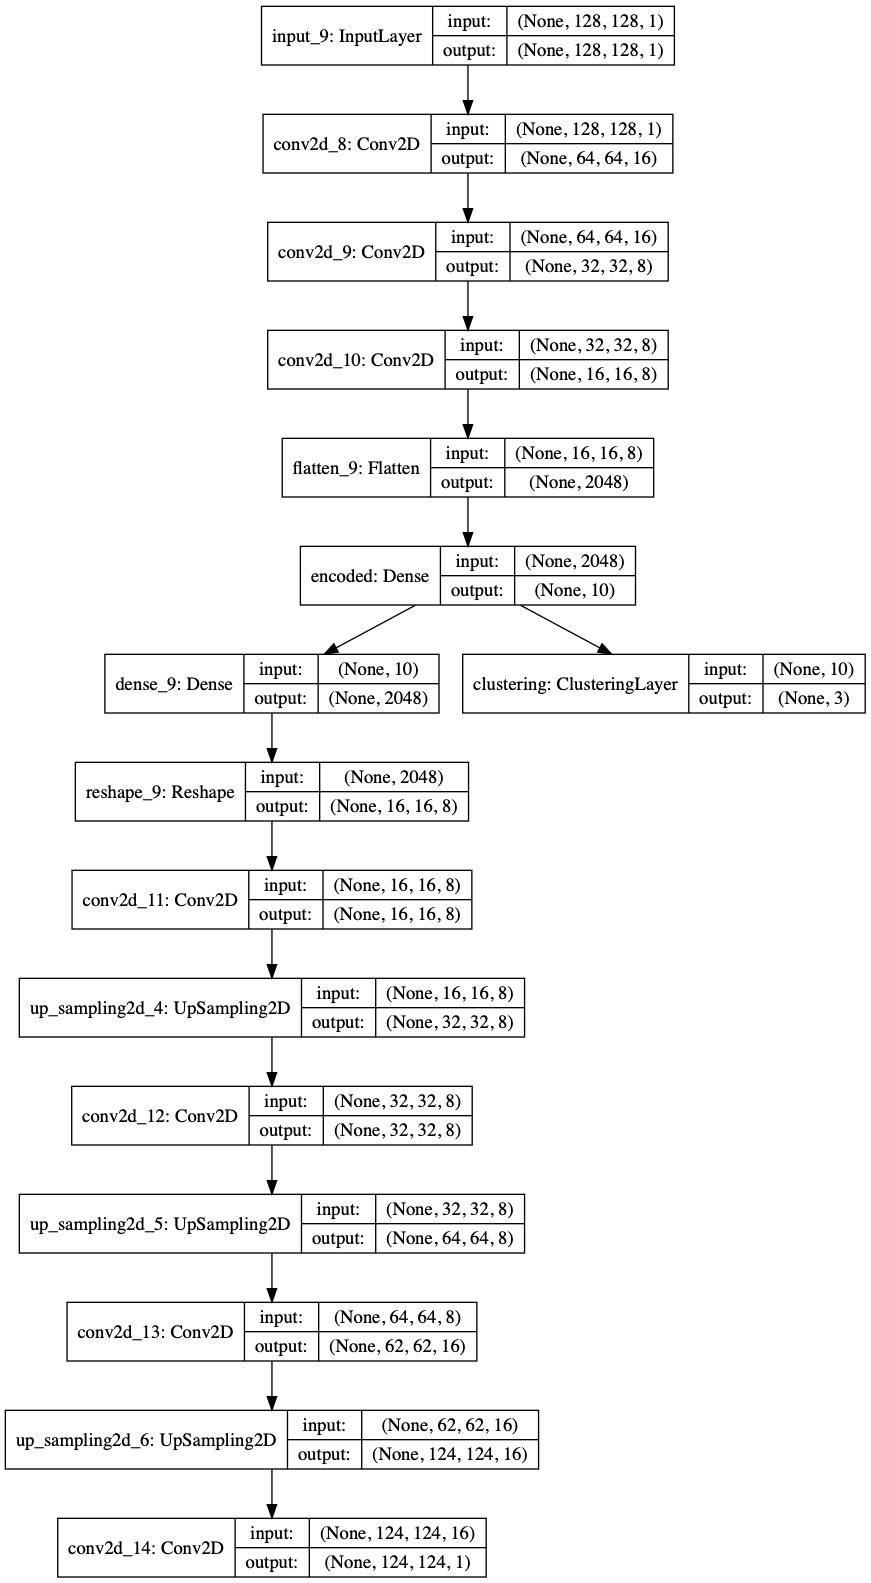

In [117]:
from keras.utils import plot_model
plot_model(model, to_file='model.png', show_shapes=True)
from IPython.display import Image
Image(filename='model.png')

In [118]:
kmeans = KMeans(n_clusters=n_clusters, n_init=20)
y_pred = kmeans.fit_predict(encoder.predict(x))
model.get_layer(name='clustering').set_weights([kmeans.cluster_centers_])
y_pred_last = np.copy(y_pred)

In [119]:
model.compile(loss=['kld', 'mse'], loss_weights=[0.1, 1], optimizer='adam')

### Deep clustering

In [120]:
# computing an auxiliary target distribution
def target_distribution(q):
    weight = q ** 2 / q.sum(0)
    return (weight.T / weight.sum(1)).T

loss = 0
index = 0
maxiter = 8000
update_interval = 140
index_array = np.arange(x.shape[0])

tol = 0.0001 # tolerance threshold to stop training

## Training

In [122]:
for ite in range(int(maxiter)):
    if ite % update_interval == 0:
        q, _  = model.predict(x, verbose=0)
        p = target_distribution(q)  # update the auxiliary target distribution p

        # evaluate the clustering performance
        y_pred = q.argmax(1)
        if y is not None:
            acc = np.round(metrics.acc(y, y_pred), 5)
            nmi = np.round(metrics.nmi(y, y_pred), 5)
            ari = np.round(metrics.ari(y, y_pred), 5)
            loss = np.round(loss, 5)
            print('Iter %d: acc = %.5f, nmi = %.5f, ari = %.5f' % (ite, acc, nmi, ari), ' ; loss=', loss)

        # check stop criterion
        delta_label = np.sum(y_pred != y_pred_last).astype(np.float32) / y_pred.shape[0]
        y_pred_last = np.copy(y_pred)
        if ite > 0 and delta_label < tol:
            print('delta_label ', delta_label, '< tol ', tol)
            print('Reached tolerance threshold. Stopping training.')
            break
    idx = index_array[index * batch_size: min((index+1) * batch_size, x.shape[0])]
    loss = model.train_on_batch(x=x[idx], y=[p[idx], x_out[idx]])
    index = index + 1 if (index + 1) * batch_size <= x.shape[0] else 0

model.save_weights(save_dir + '/b_DEC_model_final.h5')

/Users/orobix/opt/anaconda3/envs/tesi/lib/python3.6/site-packages/sklearn/utils/linear_assignment_.py:128: FutureWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  FutureWarning)


Iter 0: acc = 0.38310, nmi = 0.00688, ari = 0.00778  ; loss= 0


/Users/orobix/opt/anaconda3/envs/tesi/lib/python3.6/site-packages/sklearn/utils/linear_assignment_.py:128: FutureWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  FutureWarning)


Iter 140: acc = 0.38216, nmi = 0.00679, ari = 0.00770  ; loss= [0.00705 0.0319  0.00386]


/Users/orobix/opt/anaconda3/envs/tesi/lib/python3.6/site-packages/sklearn/utils/linear_assignment_.py:128: FutureWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  FutureWarning)


Iter 280: acc = 0.38404, nmi = 0.00738, ari = 0.00826  ; loss= [0.00932 0.04942 0.00438]


/Users/orobix/opt/anaconda3/envs/tesi/lib/python3.6/site-packages/sklearn/utils/linear_assignment_.py:128: FutureWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  FutureWarning)


Iter 420: acc = 0.37840, nmi = 0.00540, ari = 0.00624  ; loss= [0.00976 0.05016 0.00475]


/Users/orobix/opt/anaconda3/envs/tesi/lib/python3.6/site-packages/sklearn/utils/linear_assignment_.py:128: FutureWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  FutureWarning)


Iter 560: acc = 0.38216, nmi = 0.00666, ari = 0.00733  ; loss= [0.01007 0.05347 0.00472]


/Users/orobix/opt/anaconda3/envs/tesi/lib/python3.6/site-packages/sklearn/utils/linear_assignment_.py:128: FutureWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  FutureWarning)


Iter 700: acc = 0.38216, nmi = 0.00689, ari = 0.00755  ; loss= [0.00826 0.04085 0.00418]


/Users/orobix/opt/anaconda3/envs/tesi/lib/python3.6/site-packages/sklearn/utils/linear_assignment_.py:128: FutureWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  FutureWarning)


Iter 840: acc = 0.38122, nmi = 0.00721, ari = 0.00795  ; loss= [0.00684 0.04005 0.00284]


/Users/orobix/opt/anaconda3/envs/tesi/lib/python3.6/site-packages/sklearn/utils/linear_assignment_.py:128: FutureWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  FutureWarning)


Iter 980: acc = 0.38122, nmi = 0.00721, ari = 0.00795  ; loss= [0.00993 0.05528 0.0044 ]
delta_label  0.0 < tol  0.001
Reached tolerance threshold. Stopping training.


In [123]:
model.load_weights(save_dir + '/b_DEC_model_final.h5')

In [124]:
#eval
q, _ = model.predict(x, verbose=0)
p = target_distribution(q)  # update the auxiliary target distribution p

# evaluate the clustering performance
y_pred = q.argmax(1)
if y is not None:
    acc = np.round(metrics.acc(y, y_pred), 5)
    nmi = np.round(metrics.nmi(y, y_pred), 5)
    ari = np.round(metrics.ari(y, y_pred), 5)
    loss = np.round(loss, 5)
    print('Acc = %.5f, nmi = %.5f, ari = %.5f' % (acc, nmi, ari), ' ; loss=', loss)

Acc = 0.38122, nmi = 0.00721, ari = 0.00795  ; loss= [0.00993 0.05528 0.0044 ]


/Users/orobix/opt/anaconda3/envs/tesi/lib/python3.6/site-packages/sklearn/utils/linear_assignment_.py:128: FutureWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  FutureWarning)


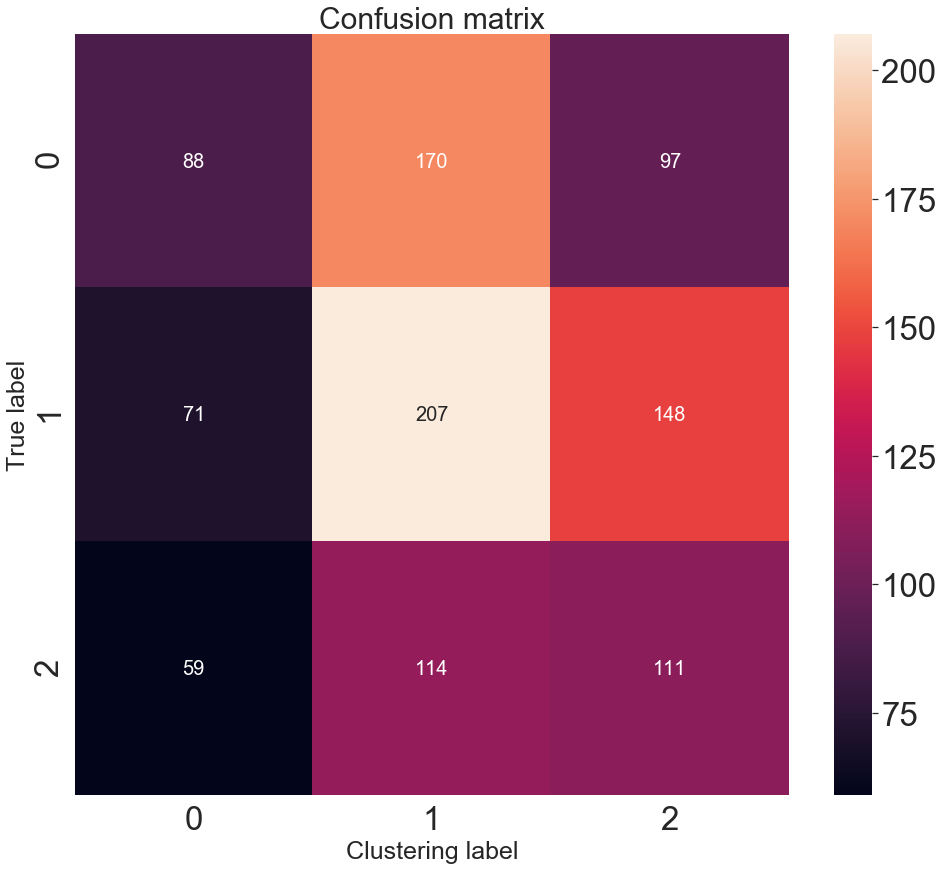

In [125]:
#confusion matrix
import seaborn as sns
import sklearn.metrics
import matplotlib.pyplot as plt
sns.set(font_scale=3)

confusion_matrix = sklearn.metrics.confusion_matrix([int(i) for i in y], y_pred)

plt.figure(figsize=(16, 14))
sns.heatmap(confusion_matrix, annot=True, fmt="d", annot_kws={"size": 20});
plt.title("Confusion matrix", fontsize=30)
plt.ylabel('True label', fontsize=25)
plt.xlabel('Clustering label', fontsize=25)
plt.show()

In [126]:
from sklearn.utils.linear_assignment_ import linear_assignment

y_true = y.astype(np.int64)
D = max(y_pred.max(), y_true.max()) + 1
w = np.zeros((D, D), dtype=np.int64)
# Confusion matrix.
for i in range(y_pred.size):
    w[y_pred[i], y_true[i]] += 1
ind = linear_assignment(-w)

sum([w[i, j] for i, j in ind]) * 1.0 / y_pred.size

/Users/orobix/opt/anaconda3/envs/tesi/lib/python3.6/site-packages/sklearn/utils/linear_assignment_.py:128: FutureWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  FutureWarning)


0.3812206572769953